### MCD - CUNEF
### Técnicas de Predicción: series temporales

Alba Rodríguez Berenguel

## HW FINAL: TOSCOS

En este trabajo voy a tratar con un fichero que contiene los datos de diez tiendas de la cadena de supermercados TOSCOS. Estos datos son diarios y van desde el 1 de enero de 2013 hasta el 31 de julio de 2015. El objetivo será predecir las ventas totales diarias y semanales, desde el 1 de agosto hasta el 10 de septiembre de 2015.

Para llevar a cabo el proyecto voy a realizar distintos notebooks. En este primer notebook, me voy a centrar principalmente en preparar los datos, de cara al diseño de los modelos de predicción. Y por otra parte, hacer algunas visualizaciones para comprender mejor su comportamiento.

Los pasos que voy a seguir son los siguientes:

1. Carga de datos.
2. Tratamiento de los valores 0 y comprobaciones previas.
3. Tratamiento de outliers.
4. Visualización de los datos.
5. Analisis de la estacionariedad y estacionalidad.
6. Exportación de los datos.

In [1]:
#Librerias empleadas en la práctica
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import statsmodels.api as sm
import numpy as np
import statistics
from sktime.transformations.series.boxcox import LogTransformer
from sktime.utils.plotting import plot_series
from statsmodels.tsa.seasonal import STL
import warnings
warnings.filterwarnings('ignore')

## 1. Carga de datos.

En primer lugar llevaré a cabo la lectura del fichero original, que contiene los datos con los que voy a trabajar *(datos.csv)* y su ordenación por tienda y fecha, para que sea más fácil de visualizar.

In [2]:
# Leo los datos, asignando que la columna fechas sea tipo datetime.
df_datos = (pd.read_csv('../data/raw/datos.csv')
            .assign(**{'Date': lambda df: pd.to_datetime(df['Date'])}))

# Para visualizar mejor los datos, ordeno el data frame por tienda y fecha.
df_datos = df_datos.sort_values(by=['Store', 'Date'])

# Establezco la columna de fechas como indice.
df_datos = df_datos.set_index('Date')

df_datos.head()

Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date                                                                      
2013-01-01   T1a          2      0          0     0      0            a   
2013-01-02   T1a          3   6072        697     1      0            0   
2013-01-03   T1a          4   5429        609     1      0            0   
2013-01-04   T1a          5   6553        709     1      0            0   
2013-01-05   T1a          6   6382        764     1      0            0   

            SchoolHoliday  
Date                       
2013-01-01              1  
2013-01-02              1  
2013-01-03              1  
2013-01-04              1  
2013-01-05              0

Las variables que tengo en el dataframe son las siguientes:

- Date: Fecha diaria.
- Store: Tienda (T1a, T1b, T1c, T2a, T2b, T2c, T3a, T3b, T3c, T3d).
- DayOfWeek: Día de la semana.
- Sales: Ventas diaria.
- Customers: Clientes diarios.
- Open: Variable categórica que indica 1 si la tienda está abierta y 0 si está cerrada.
- Promo: Variable categórica que indica 1 si hay promoción y 0 si no.
- StateHoliday: Indica 0 si es festivo y a, b o c, dependiendo del tipo de festivo.
- SchoolHoliday: Indica 0 si no es lectivo y 1 si lo es.

## 2. Tratamiento de los valores 0 y comprobaciones previas.

En la columna de ventas hay algunos valores que son 0, no son missing, sino que corresponden a días que las tiendas han estado cerradas. He decidido tratar estos valores y sustituirlos, puesto que de lo contrario influirían en los modelos, haciendo creer que las ventas son inferiores y produciendo un error mayor.

Para sustituirlos voy a analizar cada caso y decidiré los valores más adecuados que se asemejen a días cercanos, para que esto tampoco afecte negativamente a los modelos. **Los voy a corregir antes de agrupar los datos porque las tiendas no han estado cerradas los mismos días, por lo que si hay una tienda que ha estado cerrada un día, pero las demás han abierto, al agrupar no detectaría este valor nulo, ya que tomaría el valor de las ventas de las 9 tiendas restantes.**

**También, lo voy a hacer antes de realizar los gráficos, ya que si visualizo los datos antes no se aprecian claramente debido a las bajadas bruscas de los días de cierre, veremos la comparación más adelante.**

En primer lugar, voy a comprobar si hay valores nulos en el data frame.

In [3]:
df_datos.isnull().sum()

Store            0
DayOfWeek        0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

**No hay valores nulos**. Lo siguiente que voy a comprobar es si tengo el mismo numero de datos para todas las tiendas.

In [4]:
# Cuanto los valores que hay para cada tienda.
df_datos['Store'].value_counts()

T3d    942
T1a    942
T2b    942
T2a    942
T1b    942
T2c    942
T1c    942
T3c    942
T3a    942
T3b    758
Name: Store, dtype: int64

La tienda ***T3b*** tiene menos valores que el resto, deben faltar fechas. Voy a verificar que fechas faltan para añadirlas y que iguale los 942 valores que tienen las otras.

In [5]:
# Selecciono solo los datos de la tienda T3b.
comprobacion_t3b = df_datos.loc[df_datos['Store'] == 'T3b']

# Creo un rango con las fechas que debería tener.
rango_fechas = pd.date_range(start='2013-01-01', end='2015-07-31')

# Calculo la diferencia entre el rango de fechas y las del indice del df que he creado.
missing_days = rango_fechas.difference(comprobacion_t3b.index)

print(missing_days)

DatetimeIndex(['2014-07-01', '2014-07-02', '2014-07-03', '2014-07-04',
               '2014-07-05', '2014-07-06', '2014-07-07', '2014-07-08',
               '2014-07-09', '2014-07-10',
               ...
               '2014-12-22', '2014-12-23', '2014-12-24', '2014-12-25',
               '2014-12-26', '2014-12-27', '2014-12-28', '2014-12-29',
               '2014-12-30', '2014-12-31'],
              dtype='datetime64[ns]', length=184, freq=None)


Faltan un total de 184 fechas, de julio a diciembre de 2014. Las voy a añadir al dataframe y las completaré con los valores que tuvieron durante estos mismos meses en 2013.

In [6]:
# Filtro el df datos_df por la tienda T3b y las fechas faltantes pero de 2013.
t3b_2013 = df_datos.loc[df_datos['Store'] == 'T3b']['2013-07-01':'2013-12-31'].reset_index()

# Creo un vector con las fechas que faltan.
fechas = pd.date_range(start= '2014-07-01', end='2014-12-31')

# Sustituyo la columna Date por el vector con las nuevas fechas.
t3b_2013['Date'] = fechas

# Establezco la columna de fechas como indice.
t3b_2013 = t3b_2013.set_index('Date')

# Uno el df que acabo de crear con el que tiene los datos originales.
df_datos_mod = pd.concat([df_datos, t3b_2013])

# Vuelvo a ordenar los valores para que los nuevos datos no se queden al final.
df_datos_mod = df_datos_mod.sort_values(by=['Store', 'Date'])

# Compruebo el numero de valores que tiene ahora.
df_datos_mod.loc[df_datos_mod['Store'] == 'T3b']['Store'].value_counts()

T3b    942
Name: Store, dtype: int64

A continuación voy a tratar los valores 0, para ello calcularé una media movil con los 3 días anteriores.

Como en el df tengo las columnas *Store* y el resto de variables *(Sales, Customers, Open, etc.)* donde se encuentran los datos de las 10 tiendas, una seguida detrás de otra, voy a crear un bucle que filtre por cada tienda y calcule la media movil para cada una, utilizando los datos de los 3 días anteriores al valor faltante. 

Lo haré de esta manera ya que si lo hiciese sin bucle, para las columnas completas, se mezclarían los datos de las distintas tiendas. En otras palabras, los datos de las tiendas van del 01-01-2013 al 31-07-2015, cuando finalizan los datos de una tienda en 2015, la siguiente fila corresponde al comienzo de otra tienda en 2013, por lo que la media movil cogería las cifras de ventas del 29-31 de julio de 2015 de la tienda anterior para completar el día 01-01-2013 de la tienda siguiente.

También, he de decir que excepcionalmente, para el valor del 01-01-2013 he calculado la media de los 3 días posteriores, ya que no dispongo de los datos anteriores.

In [7]:
# Creo una lista para cada df, ya que voy a filtrar por cada tienda y calcular la media movil para cada una de ellas.
df_list = []

# Para cada tienda.
for tienda in df_datos_mod['Store'].unique():
    # Filtro el df por la tienda.
    df = df_datos_mod.loc[df_datos_mod['Store'] == tienda]
    # Primero, sustituyo el valor del 01-01-2013 por la media de los tres siguientes.
    df['Sales'][0] = df['Sales'][1:4].mean()
    # Calculo la media movil de orden 3.
    mm = df['Sales'].rolling(3).mean().shift(1)
    # Reemplazo los 0 por NAs, para que sea mas facil rellenarlos.
    df['Sales'] = df['Sales'].replace(0, np.nan)
    # Relleno los na con la media movil.
    df['Sales'] = df['Sales'].fillna(mm)
    # Añado el df a la lista de df.
    df_list.append(df) 
    
df_datos_mod = pd.concat(df_list)

# Compruebo si ha quedado algun 0.
for tienda in df_datos_mod['Store'].unique():
    comprobacion = df_datos_mod.loc[(df_datos_mod['Store'] == tienda) & (df_datos_mod['Sales'] == 0)]
    if len(comprobacion) > 0:
        print(tienda)

T1b
T1c
T2b
T2c


Como era de esperar, tras aplicar la media movil siguen quedando algunos valores nulos. Esto se debe a que algunas de las tiendas han estado cerradas durante períodos mayores a 3 días, por lo que no se dispone de los datos suficientes para calcular la media.

Voy a analizar las situaciones y decidiré con qué datos sustituyo los valores.

In [8]:
# La tienda t1b permaneció cerrada desde el 14-07-2014 hasta el 24-07-2014. Voy a imputarle los valores de los 11 días
# previos, es decir, del 03-07-2014 al 13-07-2014.
df_datos_mod['Sales'][1501:1512] = df_datos_mod['Sales'][1490:1501]

# Para la tienda t1c, hay 0 desde el 01-01-2013 hasta 04-07-2013. Son demasiados meses como para asignarle un valor
# constante. Le imputaré las ventas que tuvo la tienda en esas mismas fechas pero en 2014.
df_datos_mod['Sales'][1884:2069] = df_datos_mod['Sales'][2249:2434]

# La tienda t2b cerró desde el 01-04-2013 hasta el 28-04-2013. Le voy a asignar los datos de mayo desde el día 4 hasta el
# 31 porque tras la apertura las ventas fueron excesivamente altas (alcanzó valores entre 11000 y 22000) y no son los datos
# que tiene normalmente. Por otra parte, las de abril eran demasiado bajas en comparación con las que tiene tras la 
# apertura. Por estos motivos, he escogido estas fechas, que son los datos que mas se asemejan a los meses siguientes.
df_datos_mod['Sales'][3858:3886] = df_datos_mod['Sales'][3891:3919]

# La tienda t2c cerró durante el período del 06-07-2013 al 14-07-2013. Le he asignado los datos de los días previos (del
# 27 de junio al 5 de julio).
df_datos_mod['Sales'][4896:4905] = df_datos_mod['Sales'][4887:4896]

# Por ultimo, cambio la columna a tipo integer para eliminar los decimales, puesto que los datos originales no tienen.
df_datos_mod['Sales'] = df_datos_mod['Sales'].astype(int)

df_datos_mod.head()

Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date                                                                      
2013-01-01   T1a          2   6018          0     0      0            a   
2013-01-02   T1a          3   6072        697     1      0            0   
2013-01-03   T1a          4   5429        609     1      0            0   
2013-01-04   T1a          5   6553        709     1      0            0   
2013-01-05   T1a          6   6382        764     1      0            0   

            SchoolHoliday  
Date                       
2013-01-01              1  
2013-01-02              1  
2013-01-03              1  
2013-01-04              1  
2013-01-05              0

## 3. Tratamiento de outliers. 

En este apartado voy a analizar si hay valores outliers en el dataframe y su posible tratamiento. Los outliers son aquellos valores que se alejan de los valores medios que hay.

Como ya he aplicado una transformación al data frame, rellenando los valores 0 que había, es posible que a su vez haya tratado algunos outliers también. Voy a comprobar los outliers que había en el dataframe original, y posteriormente, en el ya modificado.

In [9]:
# Outliers data frame original.

for tienda in df_datos['Store'].unique():
    
    # Creo un df para cada tienda
    df_atipicos = df_datos.loc[df_datos['Store'] == tienda]['Sales']
    # Calculo el primer cuartil
    Q1 = df_atipicos.describe()['25%']
    # Calculo el tercer cuartil
    Q3 = df_atipicos.describe()['75%']
    # Calculo el rango intercuartilico
    IQR = Q3 - Q1
    # Calculo los atipicos, que son aquellos inferiores a Q1 - 1.5 * IQR y los superiores a Q3 + 1.5 * IQR
    atipicos = df_atipicos.apply(lambda x: x < (Q1 - 1.5 * IQR) or x > (Q3 + 1.5 * IQR))
    # Calculo el porcentaje
    porcentaje_atipicos = atipicos.mean() * 100

    print("El porcentaje de valores atípicos para la tienda", tienda, "es: ", porcentaje_atipicos,"%")

El porcentaje de valores atípicos para la tienda T1a es:  17.72823779193206 %
El porcentaje de valores atípicos para la tienda T1b es:  0.8492569002123143 %
El porcentaje de valores atípicos para la tienda T1c es:  0.10615711252653928 %
El porcentaje de valores atípicos para la tienda T2a es:  17.091295116772823 %
El porcentaje de valores atípicos para la tienda T2b es:  0.42462845010615713 %
El porcentaje de valores atípicos para la tienda T2c es:  18.683651804670912 %
El porcentaje de valores atípicos para la tienda T3a es:  17.40976645435244 %
El porcentaje de valores atípicos para la tienda T3b es:  18.997361477572557 %
El porcentaje de valores atípicos para la tienda T3c es:  18.577494692144374 %
El porcentaje de valores atípicos para la tienda T3d es:  0.5307855626326964 %


In [10]:
# Outliers data frame modificado.

for tienda in df_datos_mod['Store'].unique():
    
    #Creo un df para cada tienda
    df_atipicos = df_datos_mod.loc[df_datos_mod['Store'] == tienda]['Sales']
    #Calculo el primer cuartil
    Q1 = df_atipicos.describe()['25%']
    #Calculo el tercer cuartil
    Q3 = df_atipicos.describe()['75%']
    #Calculo el rango intercuartilico
    IQR = Q3 - Q1
    #Calculo los atipicos, que son aquellos inferiores a Q1 - 1.5 * IQR y los superiores a Q3 + 1.5 * IQR
    atipicos = df_atipicos.apply(lambda x: x < (Q1 - 1.5 * IQR) or x > (Q3 + 1.5 * IQR))
    #Calculo el porcentaje
    porcentaje_atipicos = atipicos.mean() * 100

    print("El porcentaje de valores atípicos para la tienda", tienda, "es: ", porcentaje_atipicos,"%")

El porcentaje de valores atípicos para la tienda T1a es:  1.8046709129511678 %
El porcentaje de valores atípicos para la tienda T1b es:  1.2738853503184715 %
El porcentaje de valores atípicos para la tienda T1c es:  3.397027600849257 %
El porcentaje de valores atípicos para la tienda T2a es:  1.167728237791932 %
El porcentaje de valores atípicos para la tienda T2b es:  2.0169851380042463 %
El porcentaje de valores atípicos para la tienda T2c es:  2.1231422505307855 %
El porcentaje de valores atípicos para la tienda T3a es:  2.547770700636943 %
El porcentaje de valores atípicos para la tienda T3b es:  2.8662420382165608 %
El porcentaje de valores atípicos para la tienda T3c es:  3.1847133757961785 %
El porcentaje de valores atípicos para la tienda T3d es:  3.290870488322718 %


Gran parte de los outliers los he tratado al rellenar los valores 0, por lo que correspondeían a los valores 0. Los porcentajes que han quedado son mínimos entre 1% - 3%, por lo que no voy a modificarlos, dado que también representan una realidad y no es una cantidad significativa que pueda interferir excesivamente en el modelo. En el caso de que fuesen porcentajes más elevados sí los trataría.

## 4. Visualización de los datos.

A continuación, voy a realizar algunas visualizaciones para comprender mejor el comportamiento de las ventas.

#### Ventas y clientes según el día de la semana 

In [11]:
#Creo un df agrupando por dias de la semana y calculando la media para ventas y clientes
agg_dw = (df_datos
           .groupby(['DayOfWeek'], as_index=False)
           .agg({'Sales': 'mean',
                'Customers': 'mean'})
           .assign(**{'DayOfWeek': lambda df: df['DayOfWeek'].replace({
        1: 'Lunes', 2: 'Martes', 3: 'Miercoles', 4:'Jueves', 5: 'Viernes', 6: 'Sabado', 7: 'Domingo'})}))

fig_dia = px.bar(agg_dw, x='DayOfWeek', y=['Sales', 'Customers'], title="Ventas y clientes según día de la semana", 
                 barmode="group", labels={'DayOfWeek':'Dias de la semana'},
                 color_discrete_sequence = ["orange", "grey"])

fig_dia.show()

Los lunes son el día que más ventas se realizan y más clientes entran a la tienda, seguido del martes. A partir de aquí comienzan a disminuir, hasta el viernes que vuelven a aumentar. Los jueves y sábados son en los que menos ventas se realizan y menos clientes acuden a las tiendas.

Los domingos las tiendas permanecen cerradas, por lo que las ventas y los clientes son nulos. **La mayoría de datos con valor 0 que hemos sustituido en el apartado anterior se deben a esto.**

#### Ventas y clientes según promoción 

In [12]:
#Creo un df agrupando por la columna promo y calculando la media para ventas y clientes
agg_promo = (df_datos
           .groupby(['Promo'], as_index=False)
           .agg({'Sales': 'mean',
                'Customers': 'mean'})
           .assign(**{'Promo': lambda df: df['Promo'].replace({
        1: 'Promocion', 0: 'No promocion'})}))

fig_promo = px.bar(agg_promo, x='Promo', y=['Sales', 'Customers'], title="Ventas y clientes según promoción", 
                   barmode="group",
                   color_discrete_sequence = ["orange", "grey"])

fig_promo.show()

Los días en los que hay promoción la media de las ventas es bastante superior a los días en los que no la hay, y por consiguiente, el número de clientes también.

#### Ventas y clientes dependiendo de si es día lectivo o no

In [13]:
#Ventas y consumidores segun días lectivos

#Creo un df agrupando por la columna SchoolHoliday y calculando la media para ventas y clientes
agg_lect = (df_datos
           .groupby(['SchoolHoliday'], as_index=False)
           .agg({'Sales': 'mean',
                'Customers': 'mean'})
           .assign(**{'SchoolHoliday': lambda df: df['SchoolHoliday'].replace({
        1: 'Lectivo', 0: 'No lectivo'})}))

fig_lect = px.bar(agg_lect, x='SchoolHoliday', y=['Sales', 'Customers'], title="Ventas y clientes según días lectivos", 
                  barmode="group",
                 color_discrete_sequence = ["orange", "grey"])

fig_lect.show()

Los clientes prefieren realizar compras los días lectivos. Como se ve en la gráfica, las ventas y el número de clientes son mayores en esos días.

#### Ventas diarias de las 10 tiendas 

En este caso voy a realizar la visualización con los datos sin modificar y los modificados, en los que he aplicado la corrección de los valores 0.

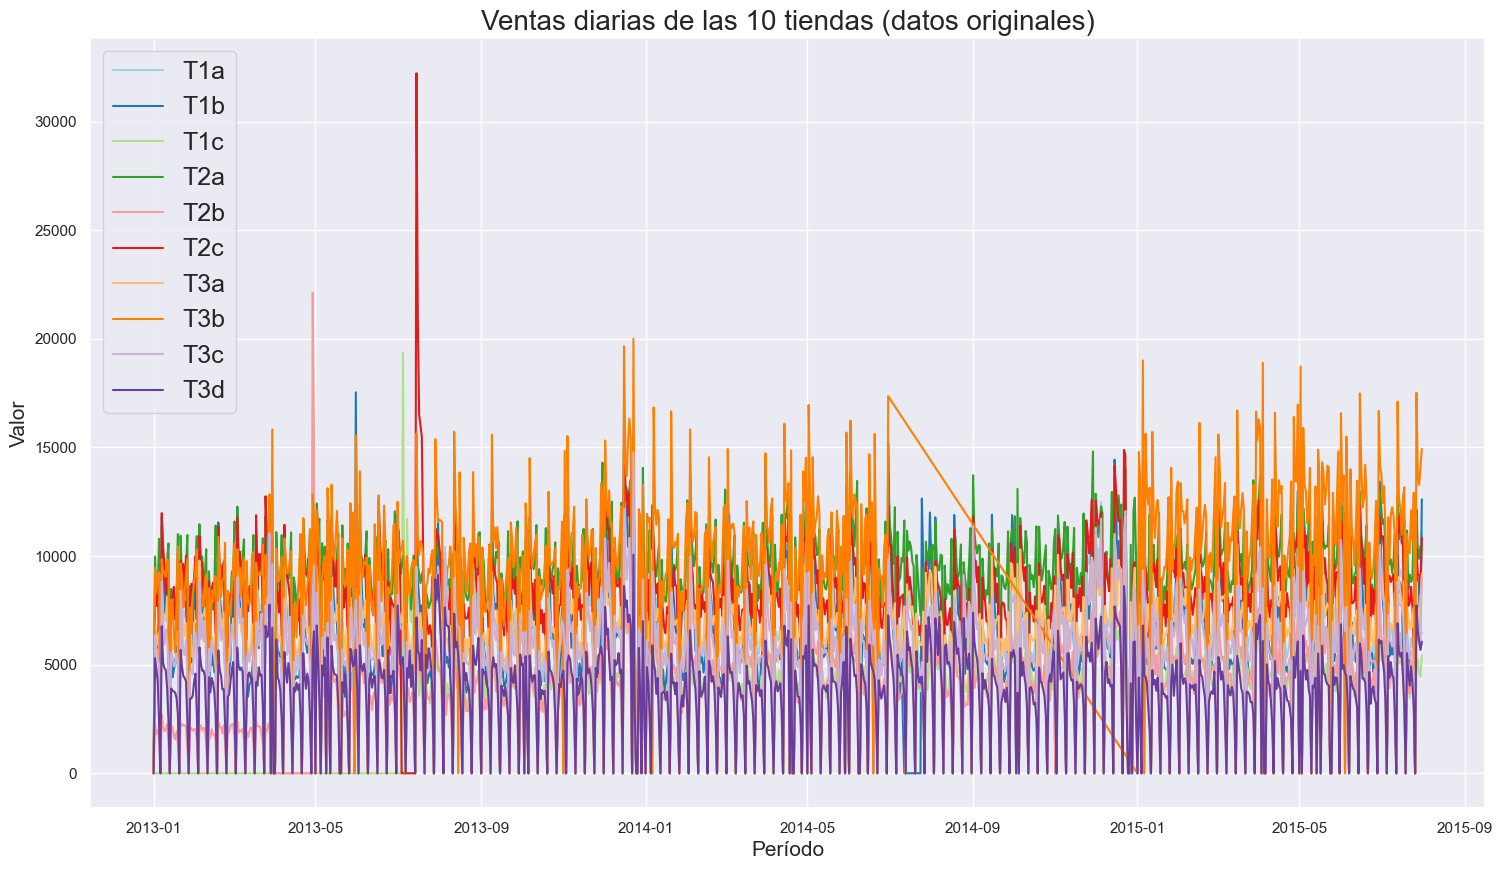

In [14]:
sns.set(rc={'figure.figsize':(18, 10)})

#Establezco el tamaño del grafico
fig, ax = plt.subplots(figsize=(18, 10))

#Colores para el grafico
name = "Paired"
cmap = get_cmap(name)  
colors = iter(cmap.colors) 

#Creo un bucle para que haga una linea para cada tienda
for tienda in df_datos['Store'].unique():
    filtered_df = df_datos.loc[lambda df: df['Store'] == tienda]
    x = filtered_df.index
    y = filtered_df['Sales']
    c = next(colors)
    ax.plot(x, y, label=tienda, alpha= 1, c = c)
    
ax.legend(fontsize=18)
ax.set_ylabel('Valor', fontsize= 15)
ax.set_xlabel('Período', fontsize= 15)
ax.set_title('Ventas diarias de las 10 tiendas (datos originales)', fontsize= 20)


plt.show()

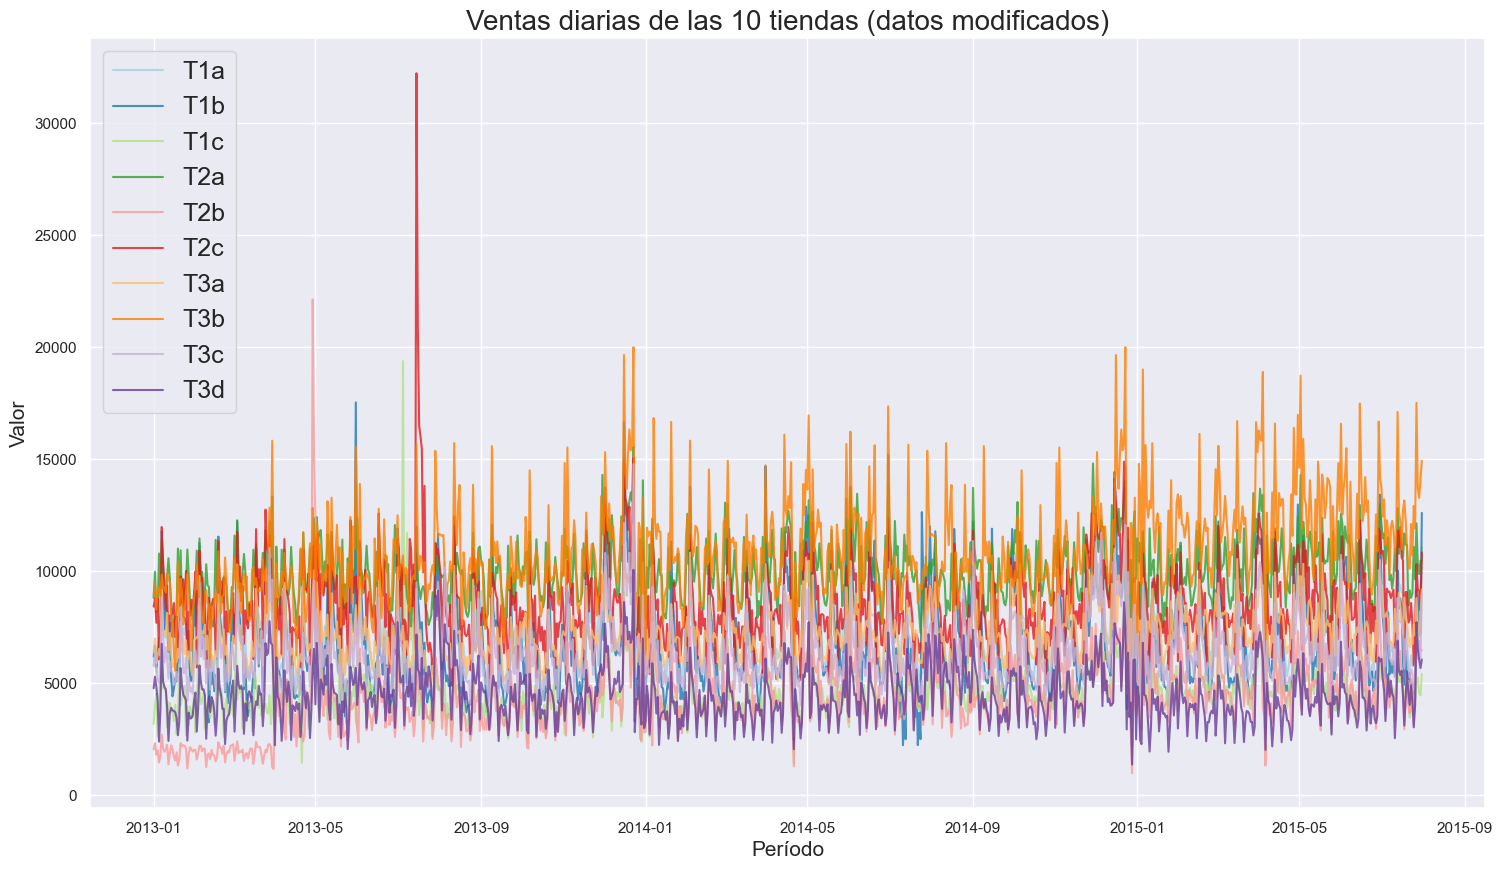

In [15]:
sns.set(rc={'figure.figsize':(18, 10)})

#Establezco el tamaño del grafico
fig, ax = plt.subplots(figsize=(18, 10))

#Colores para el grafico
name = "Paired"
cmap = get_cmap(name)  
colors = iter(cmap.colors) 

#Creo un bucle para que haga una linea para cada tienda
for tienda in df_datos_mod['Store'].unique():
    filtered_df = df_datos_mod.loc[lambda df: df['Store'] == tienda]
    x = filtered_df.index
    y = filtered_df['Sales']
    c = next(colors)
    ax.plot(x, y, label=tienda, alpha= 0.8, c = c)
    
ax.legend(fontsize=18)
ax.set_ylabel('Valor', fontsize= 15)
ax.set_xlabel('Período', fontsize= 15)
ax.set_title('Ventas diarias de las 10 tiendas (datos modificados)', fontsize= 20)


plt.show()

En la primera visualización no se pueden apreciar claramente las ventas de las distintas tiendas, principalmente por los valores 0 que probocan subidas y bajadas bruscas, que corresponden sobre todo a domingos, día que las tiendas cierran. 
También destaca la tienda T3b que se aprecia una línea con tendencia decreciente desde julio de 2014 hasta el comienzo de 2015. Este caso lo analizamos al comienzo del trabajo y esta tienda no tenía esas fechas entre sus datos.

En el segundo gráfico se visualizan mejor las ventas, estos ya son los datos en los que he sustituido los 0 y se ha corregido el caso de la T3b. Se aprecia como la tienda t2b comenzó teniendo unas ventas bastante por debajo de las del resto de tiendas y a mediados de 2013 se fue recuperando. No obstante, ha continuado siendo una de las que tiene ventas más bajas a la par que la T3d, llegando en ocasiones incluso a superarla.

Las ventas más altas las han tenido las tiendas T3b y T2a, aunque hay días que han sido superadas porque hay picos extremos, como el de la T2b (color rosa) o el de la T2c que es el más notable (color rojo), esos picos corresponden a outliers.

#### Ventas diarias de las 3 zonas 

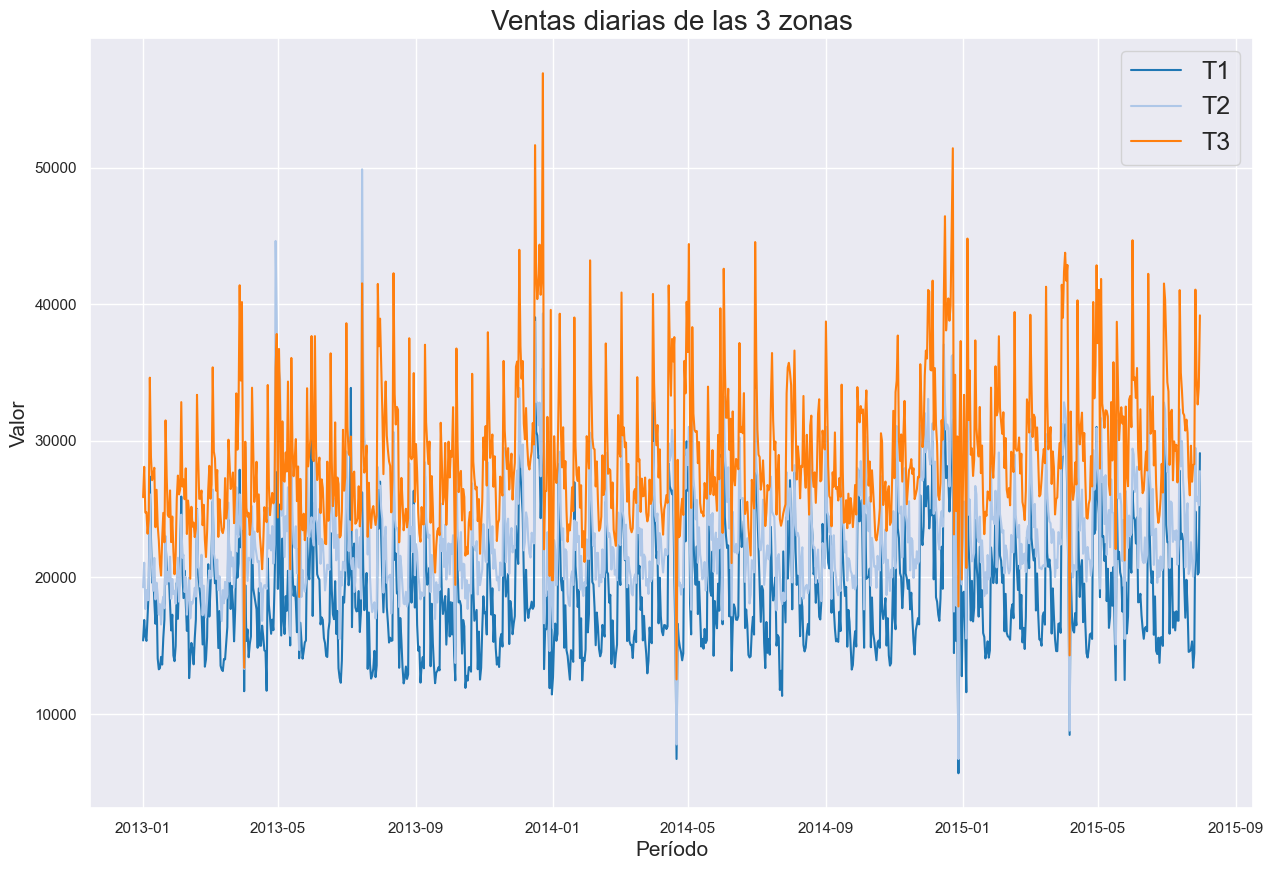

In [16]:
agg_zonas = df_datos_mod.groupby([df_datos_mod['Store'].str[:2], 'Date']).sum().reset_index()

agg_zonas = agg_zonas.set_index('Date')

fig, ax = plt.subplots(figsize=(15, 10))

#Colores para el grafico
name = "tab20"
cmap = get_cmap(name)  
colors = iter(cmap.colors) 

for zona in agg_zonas['Store'].unique():
    filtered_df = agg_zonas.loc[lambda df: df['Store'] == zona]
    x = filtered_df.index
    y = filtered_df['Sales']
    c = next(colors)
    ax.plot(x, y, label=zona, alpha= 1, c = c)
    
ax.legend(fontsize=18)
ax.set_ylabel('Valor', fontsize= 15)
ax.set_xlabel('Período', fontsize= 15)
ax.set_title('Ventas diarias de las 3 zonas', fontsize= 20)

plt.show()

La zona t1 es la que tiene las ventas más bajas y la t3 la que tiene las más altas, aunque puntualmente la t2 le supera algunos días. Las ventas de la zona t2 se encuentra entre mitad de las de estas dos zonas.

#### Ventas totales diarias.

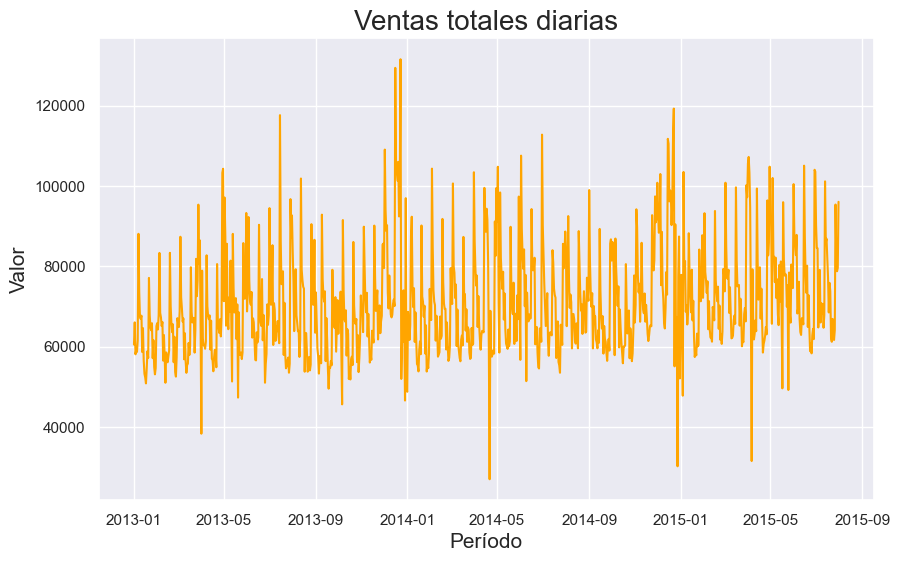

In [17]:
agg_sales_d = df_datos_mod.groupby('Date')['Sales'].sum().to_frame()

fig, ax = plt.subplots(figsize=(10, 6))

x = agg_sales_d.index
y = agg_sales_d['Sales']
ax.plot(x, y, alpha = 1, c = "orange", linewidth = 1.5)
ax.set_ylabel('Valor', fontsize= 15)
ax.set_xlabel('Período', fontsize= 15)
ax.set_title('Ventas totales diarias', fontsize= 20)

plt.show()

En el gráfico podemos observar la evolución diaria de las ventas, que tienen practicamente el mismo comportamiento a lo largo del tiempo. Se observan algunos picos, que corresponderán a outliers, pero la serie no tiene cambios muy bruscos.

#### Ventas totales semanales.

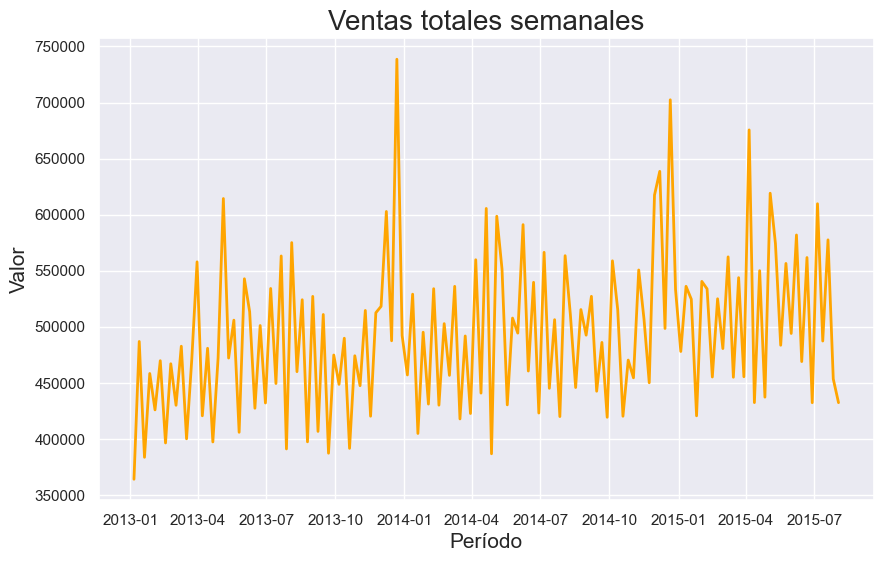

In [18]:
agg_sales_w = df_datos_mod.resample('W').sum()

fig, ax = plt.subplots(figsize=(10, 6))

x = agg_sales_w.index
y = agg_sales_w['Sales']
ax.plot(x, y, color = "orange", linewidth = 2)
ax.set_ylabel('Valor', fontsize= 15)
ax.set_xlabel('Período', fontsize= 15)
ax.set_title('Ventas totales semanales', fontsize= 20)

plt.show()

En este gráfico semanal se aprecia como las últimas semanas del año se incrementa el número de ventas, el comportamiento es muy parecido sobre todo a finales de 2014 y 2015. Esto se debe a que coincide con fechas navideñas, por lo que los clientes hacen compran más grandes que las que suelen hacer normalmente.

#### Ventas totales mensuales.

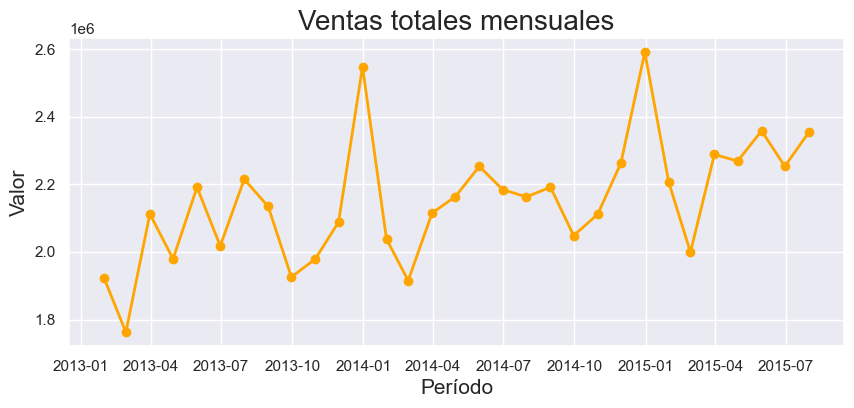

In [19]:
agg_sales_m = df_datos_mod.resample('M').sum()

fig, ax = plt.subplots(figsize=(10, 4))

x = agg_sales_m.index
y = agg_sales_m['Sales']
ax.plot(x, y, 'o-', color = "orange", linewidth = 2)
ax.set_ylabel('Valor', fontsize= 15)
ax.set_xlabel('Período', fontsize= 15)
ax.set_title('Ventas totales mensuales', fontsize= 20)

plt.show()

Se puede corroborar lo dicho con el anterior gráfico, el último mes del año es en el que mayor número de ventas se produce. También, las ventas aumentan con el paso de los años, las de 2013 son algo más bajas en algunos meses, y aunque de 2015 no tenemos los datos del año completo, de los que disponemos son mayores que los de años anteriores.

#### Crecimiento mensual de las ventas.

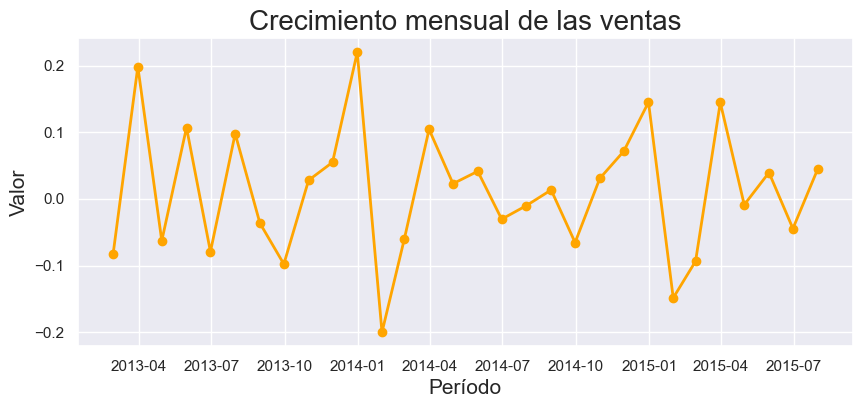

In [20]:
sales_crec = agg_sales_m.pct_change()
sales_crec.dropna(inplace=True)

fig, ax = plt.subplots(figsize=(10, 4))

x = sales_crec.index
y = sales_crec['Sales']
ax.plot(x, y, 'o-', color = "orange", linewidth = 2)
ax.set_ylabel('Valor', fontsize= 15)
ax.set_xlabel('Período', fontsize= 15)
ax.set_title('Crecimiento mensual de las ventas', fontsize= 20)

plt.show()

Esta visualización muestra que los mayores crecimientos se dan en el mes de diciembre y las mayores disminuciones en enero. Durante los meses de verano (junio - septiembre) también se dan bajadas más elevadas, coincide con el período vacacional, por lo que la gente aprovecha más para tiempo de ocio y como consecuencia harán compras menores.

## 4. Analisis de la estacionariedad y estacionalidad.

En esta sección voy a analizar la estacionariedad, estacionalidad y los componentes de la serie temporal.

In [21]:
#Primero, voy a construir la serie que voy a utilizar en los modelos. Cojo la serie original y la agrupo por la fecha,
#para sumar las ventas diarias de todas las tiendas, ya que lo que quiero predecir son las ventas TOTALES.
sales_agg = df_datos_mod.groupby('Date')['Sales'].sum().to_frame()
sales_agg.head()

Sales
Date             
2013-01-01  60541
2013-01-02  66064
2013-01-03  58120
2013-01-04  59205
2013-01-05  58703

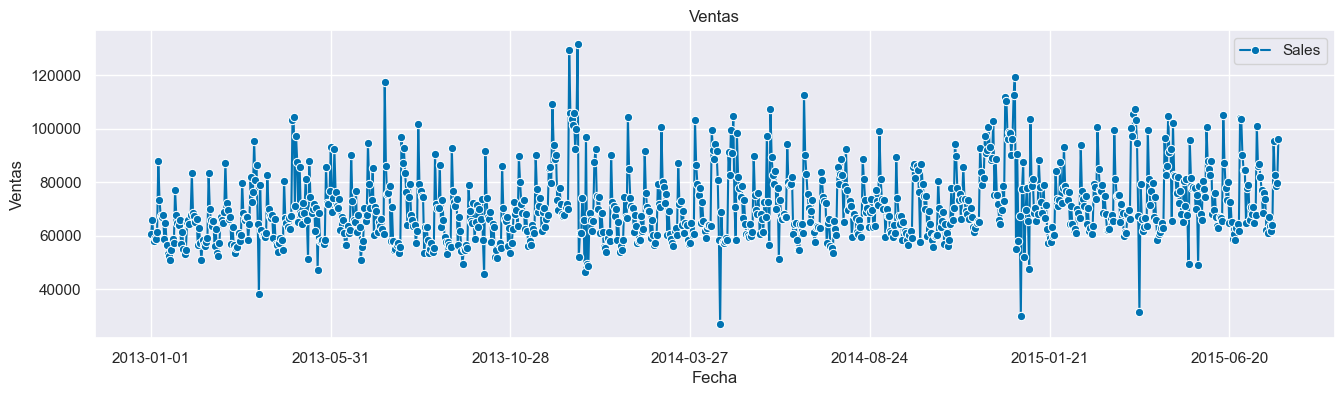

In [22]:
#La convierto a periodo diario
sales_df_d=sales_agg['Sales'].astype('float64').to_period('d').sort_index()

#Grafico
plot_series(sales_df_d, labels=["Sales"])
plt.ylabel('Ventas')
plt.xlabel('Fecha')
plt.title('Ventas')
plt.show()

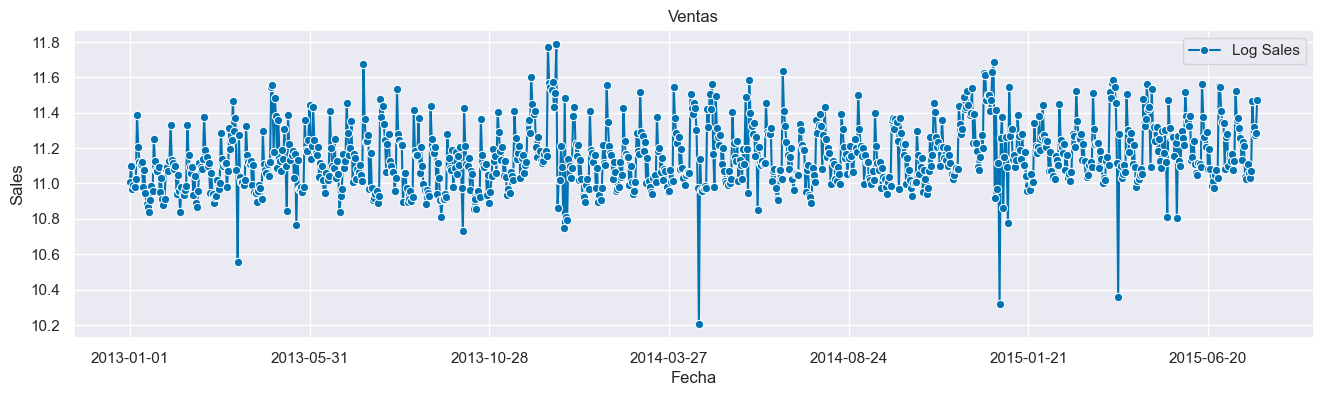

In [23]:
#Realizo la transformación logaritmica porque es necesaria para comprobar la estacionariedad en varianza
transformer = LogTransformer()
log_sales= transformer.fit_transform(sales_df_d)
log_sales.tail()

#Grafico
plot_series(log_sales, labels=["Log Sales"])
plt.ylabel('Sales')
plt.xlabel('Fecha')
plt.title('Ventas')
plt.show()

Con estas dos gráficas puedo afirmar que la serie es estacionaria en media y en varianza, ya que se mantiene practicamente constante a lo largo del tiempo, los cambios son muy similares.

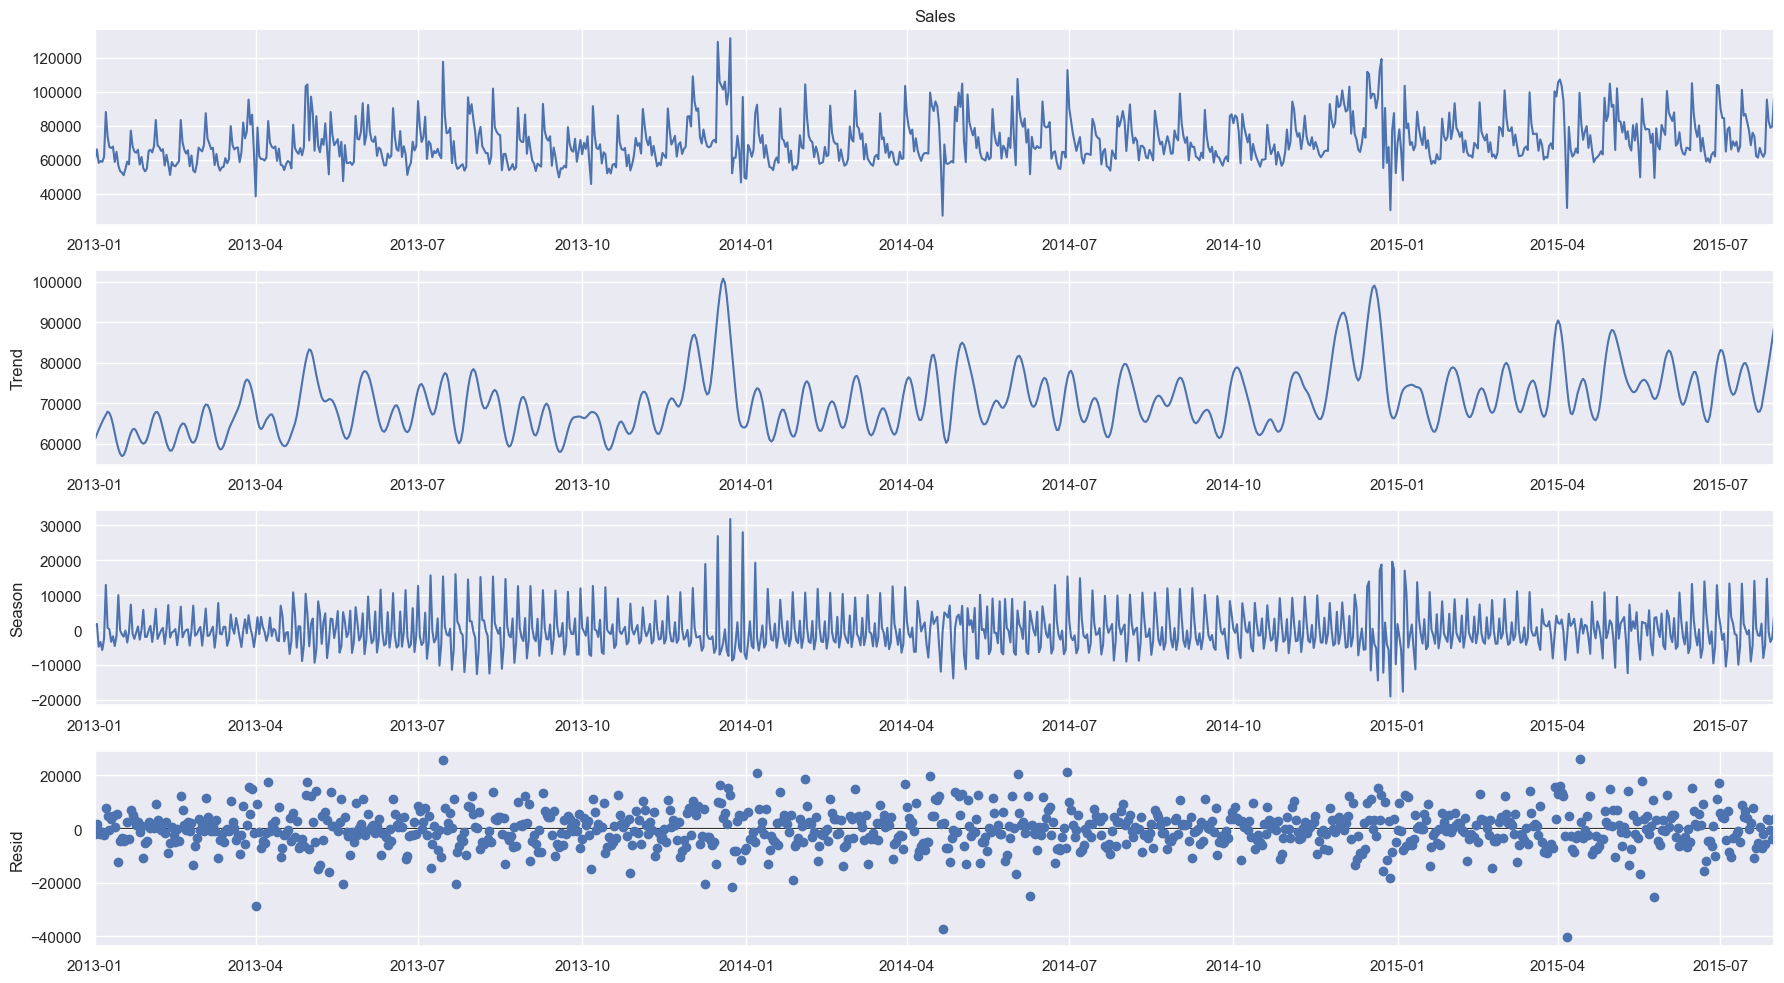

In [24]:
res = STL(sales_agg['Sales']).fit()
res.plot()
plt.show()

Por último, en cuanto a los componentes: La serie no tiene una tendencia definida, tiene subidas y bajadas que se mantienen a lo largo de toda la serie y en cuanto a su estacionalidad se aprecia una clara variación estacional hacía el final del año, coincidiendo con las festividades navideñas, el resto del año se mantiene más o menos constante.

Voy a representar su comportamiento estacional para poder confirmarlo.

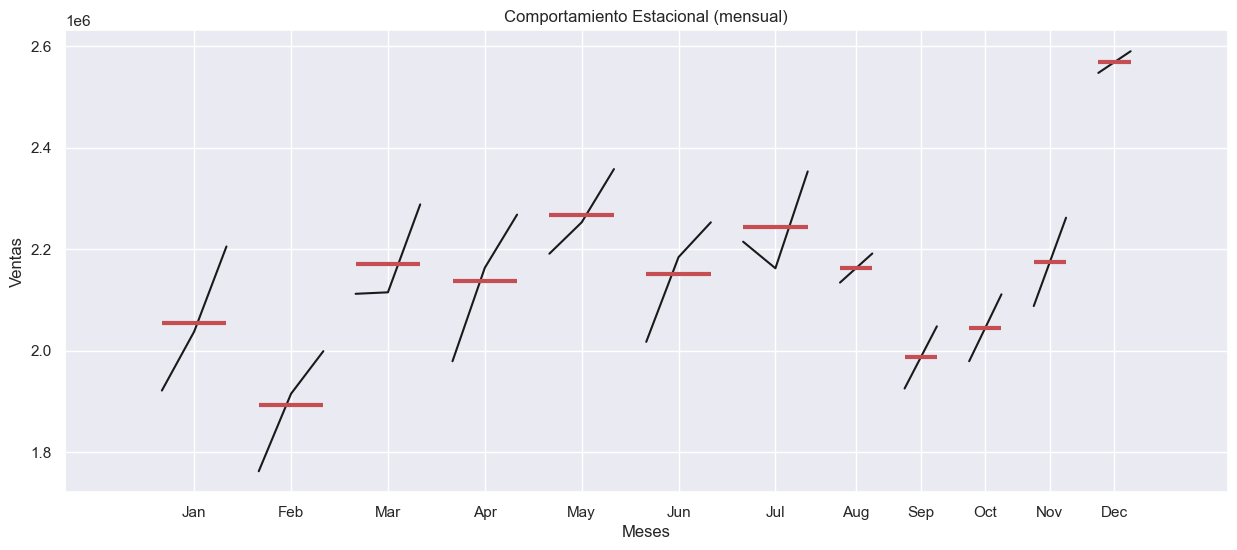

In [25]:
sales_estac = sales_agg.resample("m").sum().astype(int)

ax = plt.gca()
sm.graphics.tsa.month_plot(sales_estac['Sales'],ax=ax)
ax.set_title('Comportamiento Estacional (mensual)')
ax.set_ylabel('Ventas')
ax.set_xlabel('Meses')
ax.figure.set_size_inches(15, 6)
plt.show()

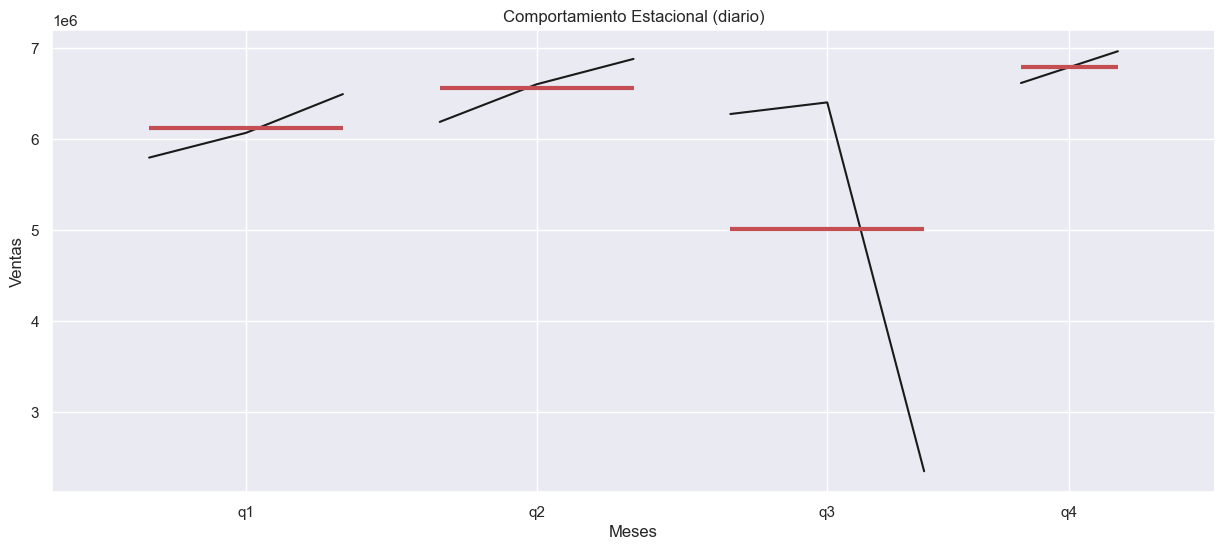

In [26]:
sales_estac = sales_agg.resample("q").sum().astype(int)

ax = plt.gca()
sm.graphics.tsa.quarter_plot(sales_estac['Sales'],ax=ax)
ax.set_title('Comportamiento Estacional (diario)')
ax.set_ylabel('Ventas')
ax.set_xlabel('Meses')
ax.figure.set_size_inches(15, 6)
plt.show()

- El último trimestre del año, y concretamente el mes de diciembre es en el que mayores ventas se realizan con diferencia. Esto es debido a que coincide con navidad y es un período de hacer compras más grandes de lo habitual, comidas familiares, etc.


- El tercer trimestre es en el que menos ventas hay, coincide con el período vacacional.


- El segundo trimestre se encuentra detrás del cuarto en cuanto a las ventas. Mayo es el mes en el que más ventas se realizan después de diciembre.


- El primer trimestre está por encima de este último, pero si echamos un vistazo al comportamiento mensual, el mes de febrero es en el que menos ventas se realizan de todo el año; en enero también disminuyen después de pasar las navidades, pero son algo más elevadas. En marzo se recuperan, de ahí que no sean las más bajas.

Como conclusión, **la serie es estacionaria en media y varianza y tiene componente estacional**.

## 5. Guardado de los datos. 

Para finalizar este notebook, voy a guardar el fichero final, al que he corregido los 0 y donde solo están las columnas que me interesan para realizar los modelos. **Estará en la carpeta data/processed del trabajo.**

In [27]:
sales_agg.to_csv('../data/processed/sales_mod.csv')